In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.integrate import odeint

In [2]:
# def rhs(y, t, ks, P0):
#     pald, pCoa = y
#     kcatf_P, Kmf_P, kcatr_P, Kmr_P = ks

#     f = lambda s, kcat, Km, E0 : (kcat*E0*s)/(Km + s)
#     fluxf_P = f(pald, kcatf_P, Kmf_P, P0)
#     fluxr_P = f(pCoa, kcatr_P, Kmr_P, P0)

#     dydt = [ -fluxf_P + fluxr_P, # pald
#              -fluxr_P + fluxf_P] # pCoa
#     return dydt

# def solveTest(tSolve, IC, ks):
#     kcatf_P, Kmf_P, kcatr_P, Kmr_P = ks
#     y0, E0s = IC
#     P0 = E0s[0]
#     sol = odeint(lambda y, t: rhs(y, t, ks, E0s[0]), y0, tSolve)
   
#     comP_sol = P0 * sol[:, 0] / (Kmf_P + sol[:, 0]) + P0 * sol[:, 1] / (Kmr_P + sol[:, 1])
#     P_sol = P0 - comP_sol

#     all_sol = np.column_stack((sol[:, 0], P_sol, comP_sol, sol[:, 1]))
#     return all_sol

## New Updates

#### Loading intial conditions

In [3]:
k_rates_df = pd.read_csv("parameters/k_rates_param_two_side.csv")

In [4]:
k_rates_df

# k_rates_df["k"][0] = 2
# k_rates_df["kr"][0] = 1
# k_rates_df["kcat"][0] = 1.5
# ksAll = [55., 15., 6., 95.]
# ksAll = list(k_rates_df.iloc[0])
k_rates_df

,kcatf_P,Kmf_P,kcatr_P,Kmr_P
0,1.5093,2.12456,0.5,1.10124


In [5]:
IC_df = pd.read_csv("parameters/init_cond.csv")
# IC_df = IC_df.drop([2,4,5,8], axis = 0)
IC_df = IC_df[0:6]
IC_df

,S,E,ES,P
0,2.50,2,0,0
1,2.75,2,0,0
2,3.00,2,0,0
3,3.25,2,0,0
4,3.50,2,0,0
5,4.00,2,0,0


In [6]:
def rhs(y, t, k_rates, IC):
    # Unpack states, params
    # S, E, ES, P = y
    pald, pCoa = y
    kcatf_P, Kmf_P, kcatr_P, Kmr_P = k_rates["kcatf_P"], k_rates["Kmf_P"], k_rates["kcatr_P"], k_rates["Kmr_P"]
    
    P0 = IC["E"]
    f = lambda s, kcat, Km, E0 : (kcat*E0*s)/(Km + s)
    fluxf_P = f(pald, kcatf_P, Kmf_P, P0)
    fluxr_P = f(pCoa, kcatr_P, Kmr_P, P0)

    dydt = [ -fluxf_P + fluxr_P, # pald
             -fluxr_P + fluxf_P] # pCoa
    return dydt


def solveTest(init_cond, k_rates, solvedT, tsID, print_to_scr = False):
    if print_to_scr:
     print("Solving for Initial Conditions: {} \n and k_rates: {}".format(init_cond, k_rates))
    
    kcatf_P, Kmf_P, kcatr_P, Kmr_P = k_rates["kcatf_P"], k_rates["Kmf_P"], k_rates["kcatr_P"], k_rates["Kmr_P"]
    y0 = [init_cond["S"], init_cond["P"]]
    P0 = init_cond["E"]
    
    sol = odeint(lambda y, t: rhs(y, t, k_rates, init_cond), y0, solvedT)
   
    comP_sol = P0 * sol[:, 0] / (Kmf_P + sol[:, 0]) + P0 * sol[:, 1] / (Kmr_P + sol[:, 1])
    P_sol = P0 - comP_sol

    all_sol = np.column_stack((sol[:, 0], P_sol, comP_sol, sol[:, 1]))

    # if print_to_file:
    #     np.savetxt('data/MM_Data_' + 'k_' + str(k_rates.values) + '__' + str(init_cond.values) + '_' + tsID + '.txt',
    #                final_sol)
    
    return all_sol

In [7]:
refinement_level = 2
final_time = 4
num_time_points = 200
t_span = (0, final_time)
time_grid_1 = np.linspace(0, final_time, num_time_points)
data_matrix_df_list = []

def get_block_symbol(feature_list):
    return ["[{}]".format(feat) for feat in feature_list]

for k_rate_index in k_rates_df.index:
    k_rates = k_rates_df.loc[k_rate_index]
    for IC_index in IC_df.index:
        IC = IC_df.loc[IC_index]
        # data_matrix_df_list.append(solveMM(IC, k_rates, time_grid_1, "dense"))
        sol = solveTest(IC, k_rates, time_grid_1, "dense")
        # sol_df = pd.DataFrame(sol, columns=['Ald', 'P', 'Pc', 'CoA'])
        sol_df = pd.DataFrame(sol, columns=IC.keys())
        sol_df["t"] = time_grid_1
        data_matrix_df_list.append(sol_df.rename(columns=dict(zip(sol_df.columns, get_block_symbol(sol_df.columns)))))

data_matrix_df = pd.concat(data_matrix_df_list, ignore_index=True)
data_matrix_df

,[S],[E],[ES],[P],[t]
0,2.500000,0.918816,1.081184,0.000000,0.000000
1,2.467589,0.868121,1.131879,0.032411,0.020101
2,2.435926,0.821757,1.178243,0.064074,0.040201
3,2.404968,0.779213,1.220787,0.095032,0.060302
4,2.374676,0.740060,1.259940,0.125324,0.080402
...,...,...,...,...,...
1195,0.944178,-0.085536,2.085536,3.055822,3.919598
1196,0.940315,-0.084283,2.084283,3.059685,3.939698
1197,0.936508,-0.083043,2.083043,3.063492,3.959799
1198,0.932759,-0.081816,2.081816,3.067241,3.979899


<Axes: >

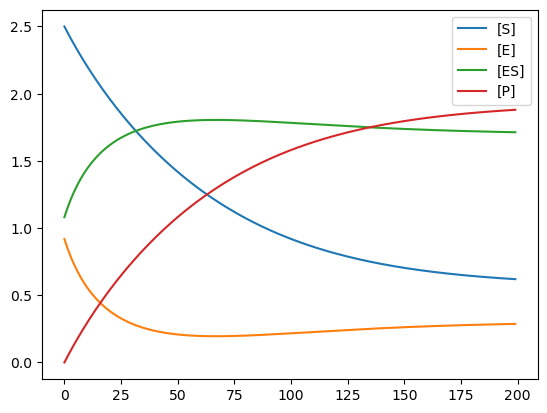

In [8]:
data_matrix_df_list[0].drop("[t]", axis=1).plot()

In [9]:
from dae_finder import add_noise_to_df
noise_perc = 0


data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    t_exact = data_matrix_["[t]"]
    noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=111)
    noisy_data_df["[t]"] = t_exact
    data_matrix_df_list[ind] = noisy_data_df

In [10]:
num_smoothed_points = num_time_points
t_eval_new = np.linspace(data_matrix_df_list[0]["[t]"].iloc[0], data_matrix_df_list[0]["[t]"].iloc[-1], num_smoothed_points)


amplify_left = 0.5
amplify_right = 3.0
amplify_factor = 1
t_length = t_span[1] - t_span[0]

num_left_points = int(num_smoothed_points * (amplify_left-t_span[0])/t_length)
num_right_points = int(num_smoothed_points * (t_span[1] - amplify_right)/t_length)

t_left = t_eval_new[:num_left_points]
t_right = t_eval_new[-num_right_points:]
t_middle = np.linspace(t_eval_new[num_left_points], t_eval_new[-(num_right_points+1)],
                       amplify_factor*(len(t_eval_new) - (num_left_points + num_right_points) ))

t_eval_new = np.concatenate((t_left, t_middle, t_right))

In [11]:
from dae_finder import smooth_data

#Calling the smoothening function
data_matrix_smooth_df_list = [smooth_data(data_matrix,domain_var="[t]",derr_order=1, noise_perc=noise_perc,
                                          eval_points=t_eval_new) for data_matrix in data_matrix_df_list]

if len(data_matrix_df_list) >1:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)
else:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0]

data_matrix_df_smooth = data_matrix_df_smooth_appended[data_matrix_features]
if "[t]" in data_matrix_df_smooth:
    data_matrix_df_smooth = data_matrix_df_smooth.drop("[t]", axis=1)

In [12]:
data_matrix_df_smooth_appended

,[t],[S],d([S]) /dt,[E],d([E]) /dt,[ES],d([ES]) /dt,[P],d([P]) /dt
0,0.000000,2.500000,-1.631778,0.918816,-2.638520,1.081184,2.638520,-1.063185e-19,1.631778
1,0.020101,2.467589,-1.593466,0.868121,-2.409972,1.131879,2.409972,3.241083e-02,1.593466
2,0.040201,2.435926,-1.557359,0.821757,-2.207657,1.178243,2.207657,6.407373e-02,1.557359
3,0.060302,2.404968,-1.523297,0.779213,-2.028955,1.220787,2.028955,9.503193e-02,1.523297
4,0.080402,2.374676,-1.491028,0.740060,-1.869838,1.259940,1.869838,1.253238e-01,1.491028
...,...,...,...,...,...,...,...,...,...
1195,3.919598,0.944178,-0.193660,-0.085536,0.062700,2.085536,-0.062700,3.055822e+00,0.193660
1196,3.939698,0.940315,-0.190780,-0.084283,0.062029,2.084283,-0.062029,3.059685e+00,0.190780
1197,3.959799,0.936508,-0.187936,-0.083043,0.061360,2.083043,-0.061360,3.063492e+00,0.187936
1198,3.979899,0.932759,-0.185129,-0.081816,0.060692,2.081816,-0.060692,3.067241e+00,0.185129


In [13]:
data_matrix_df_smooth = data_matrix_df.drop("[t]", axis=1)

In [14]:
from dae_finder import PolyFeatureMatrix

poly_degree = 3

poly_feature_ob = PolyFeatureMatrix(poly_degree)

candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)

#Dropping 1 from the candidate library since we use fit_with_intercept flag instead of using constants directly
# in the candidate library
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
candidate_lib_full

,[S],[E],[ES],[P],[S]^2,[S] [E],[S] [ES],[S] [P],[E]^2,[E] [ES],...,[E]^3,[E]^2 [ES],[E]^2 [P],[E] [ES]^2,[E] [ES] [P],[E] [P]^2,[ES]^3,[ES]^2 [P],[ES] [P]^2,[P]^3
0,2.500000,0.918816,1.081184,0.000000,6.250000,2.297040,2.702960,0.000000,0.844223,0.993409,...,0.775686,0.912760,0.000000,1.074058,0.000000,0.000000,1.263859,0.000000,0.000000,0.000000
1,2.467589,0.868121,1.131879,0.032411,6.088996,2.142167,2.793011,0.079977,0.753635,0.982608,...,0.654246,0.853023,0.024426,1.112193,0.031847,0.000912,1.450105,0.041523,0.001189,0.000034
2,2.435926,0.821757,1.178243,0.064074,5.933737,2.001739,2.870113,0.156079,0.675285,0.968229,...,0.554920,0.795649,0.043268,1.140810,0.062038,0.003374,1.635704,0.088951,0.004837,0.000263
3,2.404968,0.779213,1.220787,0.095032,5.783871,1.873983,2.935953,0.228549,0.607173,0.951253,...,0.473117,0.741229,0.057701,1.161277,0.090399,0.007037,1.819364,0.141628,0.011025,0.000858
4,2.374676,0.740060,1.259940,0.125324,5.639087,1.757402,2.991950,0.297603,0.547688,0.932431,...,0.405322,0.690055,0.068638,1.174807,0.116856,0.011623,2.000091,0.198945,0.019789,0.001968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0.944178,-0.085536,2.085536,3.055822,0.891473,-0.080761,1.969118,2.885241,0.007316,-0.178389,...,-0.000626,0.015259,0.022358,-0.372037,-0.545125,-0.798741,9.070959,13.291179,19.474834,28.535405
1196,0.940315,-0.084283,2.084283,3.059685,0.884192,-0.079252,1.959881,2.877067,0.007104,-0.175669,...,-0.000599,0.014806,0.021735,-0.366144,-0.537492,-0.789027,9.054612,13.291990,19.512376,28.643779
1197,0.936508,-0.083043,2.083043,3.063492,0.877048,-0.077770,1.950787,2.868986,0.006896,-0.172981,...,-0.000573,0.014365,0.021126,-0.360327,-0.529927,-0.779353,9.038460,13.292693,19.549313,28.750807
1198,0.932759,-0.081816,2.081816,3.067241,0.870040,-0.076315,1.941833,2.860997,0.006694,-0.170326,...,-0.000548,0.013935,0.020532,-0.354587,-0.522430,-0.769722,9.022502,13.293292,19.585654,28.856499


In [15]:
#scaling the candidate columns to set std of 1
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler(with_std=True, with_mean=False)
scaled_cand_lib = pd.DataFrame(s_scaler.fit_transform(candidate_lib_full), columns=s_scaler.feature_names_in_)
if '1' in scaled_cand_lib.columns:
        scaled_cand_lib['1'] = 1

In [16]:
scaled_cand_lib.describe()

,[S],[E],[ES],[P],[S]^2,[S] [E],[S] [ES],[S] [P],[E]^2,[E] [ES],...,[E]^3,[E]^2 [ES],[E]^2 [P],[E] [ES]^2,[E] [ES] [P],[E] [P]^2,[ES]^3,[ES]^2 [P],[ES] [P]^2,[P]^3
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1.200000e+03,1200.000000,...,1200.000000,1.200000e+03,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,2.015694,0.429242,9.678461,2.352509,0.973467,0.307794,2.089078,2.501982,4.924387e-01,0.367768,...,0.246514,6.136971e-01,1.003982,0.278843,0.135045,0.085387,3.525811,1.991899,1.407288,1.106181
std,1.000417,1.000417,1.000417,1.000417,1.000417,1.000417,1.000417,1.000417,1.000417e+00,1.000417,...,1.000417,1.000417e+00,1.000417,1.000417,1.000417,1.000417,1.000417,1.000417,1.000417,1.000417
min,0.844142,-1.316039,5.464143,0.000000,0.137007,-1.241495,0.788234,0.000000,2.070893e-08,-1.752805,...,-0.254353,3.164849e-08,0.000000,-2.164730,-2.381223,-2.454552,0.615328,0.000000,0.000000,0.000000
25%,1.216257,-0.261627,9.093158,1.702954,0.284421,-0.162413,1.265079,1.805275,3.808575e-02,-0.316294,...,-0.001998,5.796694e-02,0.136587,-0.354571,-0.347770,-0.271605,2.835859,1.385810,0.615973,0.278266
50%,1.687728,0.374996,9.732707,2.524420,0.547668,0.163544,1.838832,2.363723,1.796853e-01,0.425517,...,0.005885,2.754090e-01,0.669947,0.447725,0.301308,0.126336,3.477294,1.979602,1.265660,0.906432
75%,2.611917,1.014546,10.369331,3.075219,1.311687,0.392667,2.715819,3.121050,5.179477e-01,1.075580,...,0.116532,7.503313e-01,1.558026,1.057351,0.783891,0.727500,4.205258,2.701136,2.007079,1.638619
max,5.447039,4.643560,11.423742,4.283780,5.704695,5.845108,4.889461,4.785594,8.966259e+00,2.958215,...,11.173364,7.407743e+00,3.731005,1.928240,1.768054,1.840353,5.622968,4.034762,4.140495,4.429258


In [17]:
import sympy

from dae_finder import get_refined_lib, remove_paranth_from_feat

# Adding the state variables as scipy symbols
feat_list = list(data_matrix_df.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

In [18]:
from dae_finder import sequentialThLin, AlgModelFinder
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       fit_intercept=True)

algebraic_model_lasso.fit(data_matrix_df_smooth, scale_columns= True)
algebraic_model_lasso.best_models(10) # Best 10 models using R2 matrix

,[E],[ES],[P],[S]
[S],0.00,-0.00,-5.947538e-01,NaN
[ES],-0.90,NaN,3.432375e-16,4.395021e-16
[P],-0.00,0.00,NaN,-8.579271e-01
[E],NaN,-0.90,-1.552195e+00,-1.015900e+00
r2- metric,0.99,0.99,8.356130e-01,7.170941e-01


In [19]:
algebraic_model_lasso.get_fitted_intercepts()

{'[S]': 3.0146077883704163,
 '[E]': 1.8092473820679245,
 '[ES]': 1.9923369415364547,
 '[P]': 2.6997750066650394}

In [20]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
# lin_model.fit(candidate_lib_full[["[Pc]"]], candidate_lib_full["[P]"])
lin_model.fit(candidate_lib_full[["[ES]"]], candidate_lib_full["[E]"])

print(dict(zip(lin_model.feature_names_in_, lin_model.coef_)))
print(lin_model.intercept_)

{'[ES]': -0.9999999999999993}
1.999999999999999


In [21]:
features_to_remove = {ES}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

In [22]:
refined_candid_lib

,[S],[E],[P],[S]^2,[S] [E],[S] [P],[E]^2,[E] [P],[P]^2,[S]^3,[S]^2 [E],[S]^2 [P],[S] [E]^2,[S] [E] [P],[S] [P]^2,[E]^3,[E]^2 [P],[E] [P]^2,[P]^3
0,2.500000,0.918816,0.000000,6.250000,2.297040,0.000000,0.844223,0.000000,0.000000,15.625000,5.742600,0.000000,2.110557,0.000000,0.000000,0.775686,0.000000,0.000000,0.000000
1,2.467589,0.868121,0.032411,6.088996,2.142167,0.079977,0.753635,0.028137,0.001050,15.025141,5.285988,0.197349,1.859661,0.069429,0.002592,0.654246,0.024426,0.000912,0.000034
2,2.435926,0.821757,0.064074,5.933737,2.001739,0.156079,0.675285,0.052653,0.004105,14.454145,4.876090,0.380197,1.644943,0.128259,0.010001,0.554920,0.043268,0.003374,0.000263
3,2.404968,0.779213,0.095032,5.783871,1.873983,0.228549,0.607173,0.074050,0.009031,13.910026,4.506869,0.549652,1.460232,0.178088,0.021719,0.473117,0.057701,0.007037,0.000858
4,2.374676,0.740060,0.125324,5.639087,1.757402,0.297603,0.547688,0.092747,0.015706,13.391006,4.173261,0.706712,1.300583,0.220244,0.037297,0.405322,0.068638,0.011623,0.001968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0.944178,-0.085536,3.055822,0.891473,-0.080761,2.885241,0.007316,-0.261383,9.338046,0.841709,-0.076253,2.724181,0.006908,-0.246793,8.816781,-0.000626,0.022358,-0.798741,28.535405
1196,0.940315,-0.084283,3.059685,0.884192,-0.079252,2.877067,0.007104,-0.257878,9.361675,0.831418,-0.074522,2.705348,0.006680,-0.242487,8.802920,-0.000599,0.021735,-0.789027,28.643779
1197,0.936508,-0.083043,3.063492,0.877048,-0.077770,2.868986,0.006896,-0.254400,9.384980,0.821363,-0.072832,2.686830,0.006458,-0.238248,8.789114,-0.000573,0.021126,-0.779353,28.750807
1198,0.932759,-0.081816,3.067241,0.870040,-0.076315,2.860997,0.006694,-0.250949,9.407966,0.811537,-0.071183,2.668621,0.006244,-0.234075,8.775367,-0.000548,0.020532,-0.769722,28.856499


<img src="deriv.jpeg" width="600">

In [23]:
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       fit_intercept=False, alpha=0.1)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)

AlgModelFinder()

In [24]:
best_models_full = algebraic_model_lasso.best_models()

In [25]:
best_models_full

,[P]^2,[S]^2,[S] [E],[E] [P],[E]^2,[S] [P]^2,[E],[P],[S] [P],[S] [E]^2,[S],[S]^2 [P],[S]^3,[S]^2 [E],[P]^3,[E]^3,[E] [P]^2,[S] [E] [P],[E]^2 [P]
[S],-0.000000,1.312613,0.000000,0.000000,0.003097,-0.000000,0.002599,0.000000,0.005251,0.000000,NaN,1.679141,0.000000,0.000000,-0.177640,-0.000000,-0.010800,0.000000,-0.000000
[E],-0.000000,0.000000,0.786516,0.000010,0.008751,-0.000000,NaN,0.000000,-0.000000,0.000000,0.815509,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.397679,0.000000
[P],1.178283,-0.099975,-0.000000,0.003332,0.000000,0.125310,0.000000,NaN,0.547618,-0.000000,0.000000,-0.000000,-0.051559,-0.012535,0.000000,-0.000000,-0.000000,-0.000000,0.009961
[S]^2,-0.000000,NaN,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.245320,0.000000,2.838695,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000
[S] [E],-0.000000,0.000000,NaN,0.000000,0.000000,-0.000000,0.233868,0.000000,-0.000000,0.000000,0.000000,-1.693876,0.000000,2.093983,0.000000,0.000000,-0.000000,0.000000,-0.000000
[S] [P],0.000000,-0.000000,-0.000000,0.000000,0.000000,0.905778,0.000000,0.342060,NaN,-0.000000,0.330403,0.416135,-0.641370,-0.000000,-0.000000,-0.001891,-0.000000,-0.008023,0.005936
[E]^2,-0.000000,0.000000,0.000000,0.000000,NaN,-0.000000,0.276597,-0.000000,0.000000,1.591640,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.605090,-0.000000,-0.000000,0.294852
[E] [P],-0.000000,-0.000000,0.000000,NaN,0.000000,-0.000000,0.296735,0.734817,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,1.777536,0.874385,0.023337
[S]^3,-0.000000,0.161356,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000753,0.000000,0.000000,NaN,0.009236,-0.000000,-0.000000,-0.000000,0.000000,-0.000000
[S]^2 [E],-0.000000,0.000000,0.210365,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.034273,0.000000,-0.000000,0.000000,NaN,0.000000,0.000000,-0.000000,0.000000,-0.003908


In [30]:
best_models_full

,[Pc] [CoA],[Pc] [CoA]^2,[Ald]^2,[Ald] [Pc],[Pc]^2 [CoA],[CoA]^2,[Ald] [CoA],[Ald] [Pc]^2,[Ald] [Pc] [CoA],[Pc]^2,[Ald]^2 [Pc],[Pc]^3,[CoA],[Ald]^2 [CoA],[CoA]^3,[Ald] [CoA]^2,[Ald],[Ald]^3,[Pc]
[Ald],-0.000000,-0.000000,1.540433,0.840636,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.018540,0.000000,-0.016538,-0.161553,-0.484343,0.998991,0.000000,NaN,-0.575813,0.413030
[Pc],0.000000,-0.000000,-0.402968,0.043101,0.000000,-0.000000,0.000000,0.094561,-0.377839,1.139008,-0.581179,1.064092,0.523983,-0.887001,-1.604319,-0.543239,0.553102,-2.573095,NaN
[CoA],1.169903,0.000000,-0.000000,-0.000000,1.065758,0.896855,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.027541,NaN,-0.000000,-0.000000,-0.000000,-0.260397,2.565953,0.650609
[Ald]^2,-0.000000,-0.000000,NaN,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.221141,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.157110,3.820649,-0.000000
[Ald] [Pc],-0.000000,-0.001333,0.000000,NaN,-0.000000,-0.003396,0.000000,1.220974,0.000000,-0.000000,0.283916,-0.000000,-0.032753,-0.000000,0.000000,-0.000000,0.161556,-0.000000,0.005511
[Ald] [CoA],0.000000,0.000000,-0.000000,-0.000000,0.020451,-0.000000,NaN,0.000000,2.013844,0.211599,-0.000000,1.854679,-0.000000,0.890328,-0.000000,0.000000,-0.000000,-0.451883,0.000000
[Pc]^2,0.000000,-0.000000,-0.000000,0.000000,0.000481,-0.000000,0.147282,0.000000,0.000000,NaN,-0.000000,0.352780,0.000000,0.000000,-0.147110,-0.000000,-0.000000,-0.317289,0.214509
[CoA]^2,0.017925,1.160274,-0.000000,-0.001695,0.000000,NaN,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.091320,-0.000000,1.141431,0.000000,0.000000,0.000000,-0.086914
[Ald]^3,-0.000000,-0.000000,0.139952,0.000000,-0.000000,0.000000,-0.001090,0.000000,0.000000,-0.000000,0.232952,-0.000000,0.000000,-0.004903,0.000000,-0.000000,-0.000000,NaN,-0.011305
[Ald]^2 [Pc],-0.000000,-0.002685,0.073683,0.005154,-0.000000,-0.000000,-0.000000,0.011555,0.000000,-0.000000,NaN,-0.000000,0.000000,0.000000,0.000000,-0.002695,-0.000000,0.000000,-0.000000


In [152]:
from dae_finder import get_simplified_equation_list

intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.025,
                            intercept_threshold= 0.01,
                             global_feature_list=data_matrix_df.columns,
                             intercept_dict= intercept_dictionary,
                             simplified = True)

In [154]:
simplified_equations['[Ald] [Pc] [CoA]']

{'lhs': [Ald]*[Pc],
 'rhs': 0.0850271533330318*[Ald] + 0.341400381925314*[Pc]**2}

In [155]:
from dae_finder import construct_reduced_fit_list

reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)

reduced_relationship_features

***Warning: exception occured while trying to find the monomials of 0.0985548493219746:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 0.0526249745210209:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 7.85407935820088:  Cannot initialize from 'dict' without generators


[['[Ald] [Pc]', '[Ald]', '[Pc]^3', '[Pc]^2'],
 ['[Ald] [Pc]', '[Ald]', '[Pc]^2'],
 ['[CoA]', '[CoA]^2', None],
 ['[Ald]', '[Pc]'],
 ['[Ald]', '[Ald] [Pc]', '[Pc]'],
 ['[Ald] [Pc]', '[Ald]', '[Pc]^2'],
 ['[Pc]'],
 ['[Pc]', '[Pc]^2', None],
 ['[Pc]'],
 ['[Pc] [CoA]', '[Pc] [CoA]^2', '[Pc]^2 [CoA]', '[CoA]', '[Pc]'],
 ['[Ald] [CoA]', '[Ald] [CoA]^2', '[Ald] [Pc] [CoA]', '[Pc]^2 [CoA]', '[Pc]'],
 ['[Ald]', '[Pc]'],
 ['[Ald]^2 [CoA]', '[Ald] [Pc] [CoA]', '[Pc]^3', '[Pc]^2'],
 ['[Pc]', '[Ald]', '[Pc] [CoA]'],
 ['[CoA]'],
 ['[Ald]', '[Ald] [Pc]', '[Pc]'],
 ['[Pc] [CoA]', '[CoA]', '[Pc]'],
 ['[Ald] [CoA]', '[Ald]', '[Pc]^2'],
 ['[CoA]', '[CoA]^2', '[Pc] [CoA]', '[Pc]']]

In [54]:
from sklearn.linear_model import LinearRegression

#Removing None from reduced relationship features if it is present. Whenever a constant appears in either LHS or RHS of the relationship,
# while converting the sympy symbol to feature name corresponding to the canddiate library, a None is returned. 

best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)
    
lin_model = LinearRegression()

best_relation_lhs = best_relationship[0]
best_relation_rhs = best_relationship[1:]
lin_model.fit(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])
lin_model.score(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])

0.9719181063895739

In [74]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'[Ald]': 0.054198941413156676, '[Pc]^2': 23.02722461730923}

In [62]:
df_ = algebraic_model_lasso.best_models()
{key_: value_ for key_, value_ in dict(df_["[Ald] [Pc] [CoA]"]).items() if abs(value_)>0.01}

{'[Ald]': 0.04945973288768553,
 '[Pc]^2': 1.5907796513447916,
 '[Pc]^3': 45.389415996623875,
 'r2- metric': 0.9904413304732355}

In [167]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(candidate_lib_full[["[Ald] [CoA]", "[Ald]", "[CoA]", "[Ald] [Pc]", "[Pc] [CoA]", "[Pc]"]], candidate_lib_full["[Ald] [Pc] [CoA]"]).score(candidate_lib_full[["[Ald] [CoA]", "[Ald]", "[CoA]", "[Ald] [Pc]", "[Pc] [CoA]", "[Pc]"]], candidate_lib_full["[Ald] [Pc] [CoA]"])

1.0

In [166]:
lin_model.intercept_

-1.3069545445887343e-12

In [3]:
# Define all ICs

IC1 = ([0.5, 0.], [0.694]) # y0, E0
IC2 = ([1., 0.], [0.694])
IC3 = ([1.5, 0.], [0.694])
IC4 = ([5., 0.], [0.694])
IC5 = ([10., 0.], [0.694])
IC6 = ([0., 0.5], [0.694])
IC7 = ([0., 1.], [0.694])
IC8 = ([0., 1.5], [0.694])
IC9 =  ([0., 5.], [0.694])
IC10 = ([0., 10.], [0.694])
ICs = [IC1, IC2, IC3, IC4, IC5, IC6, IC7, IC8, IC9, IC10]

ksAll = [55., 15., 6., 95.]

tSolve = np.linspace(0, .6, 5000)
outs = [solveTest(tSolve, IC, ksAll) for IC in ICs]

Dropdown(description='IC:', index=7, options=('IC1', 'IC2', 'IC3', 'IC4', 'IC5', 'IC6', 'IC7', 'IC8', 'IC9', '…

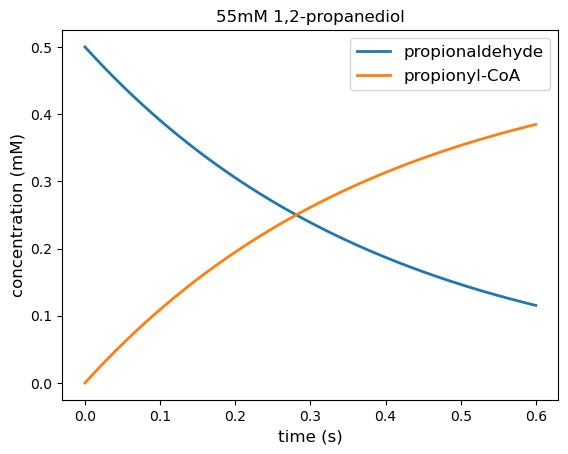

In [8]:
from IPython.display import display, clear_output

data = {
    'IC1' : outs[0][:, [0,3]],
    'IC2' : outs[1][:, [0,3]],
    'IC3' : outs[2][:, [0,3]],
    'IC4' : outs[3][:, [0,3]],
    'IC5' : outs[4][:, [0,3]],
    'IC6' : outs[5][:, [0,3]],
    'IC7' : outs[6][:, [0,3]],
    'IC8' : outs[7][:, [0,3]],
    'IC9' : outs[8][:, [0,3]],
    'IC10' : outs[9][:, [0,3]]
}

titles = {
    'IC1' : '55mM 1,2-propanediol',
    'IC2' : '55mM propionaldehyde',
    'IC3' : '55mM 1-propanol',
    'IC4' : '55mM propionyl-CoA',
    'IC5' : '25mM 1,2-propanediol, 20mM 1-propanol, 10 mM propionyl-CoA',
    'IC6' : '25mM 1,2-propanediol, 10mM 1-propanol, 20 mM propionyl-CoA',
    'IC7' : '13.75mM all upstream species',
    'IC8' : '15mM 1,2-propanediol',
    'IC9' : '35mM 1,2-propanediol',
    'IC10' :'55mM propionate'
}

def plotThisIC(dat, title):
    plt.plot(tSolve, dat, lw=2, label=['propionaldehyde', 'propionyl-CoA'])
    plt.xlabel('time (s)', fontsize=12)
    plt.ylabel('concentration (mM)', fontsize=12)
    plt.title(title)
    plt.legend(fontsize=12)


# Dropdown menu setup
dropdown = widgets.Dropdown(
    options=list(data.keys()),
    value='IC8',
    description='IC:'
)

def on_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        clear_output()
        display(dropdown)
        plotThisIC(data[change['new']], titles[change['new']])

# Display the dropdown menu and the plot
display(dropdown)
plotThisIC(data['IC1'], titles['IC1'])
dropdown.observe(on_change)


Dropdown(description='IC:', options=('IC1', 'IC2', 'IC3', 'IC4', 'IC5', 'IC6', 'IC7', 'IC8', 'IC9', 'IC10'), v…

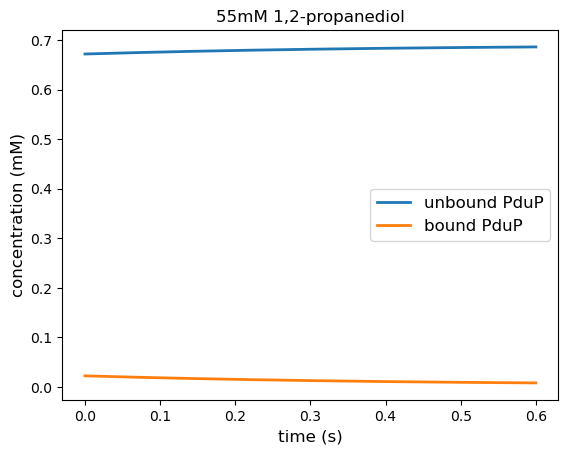

In [5]:
from IPython.display import display, clear_output

data = {
    'IC1' : outs[0][:, [1,2]],
    'IC2' : outs[1][:, [1,2]],
    'IC3' : outs[2][:, [1,2]],
    'IC4' : outs[3][:, [1,2]],
    'IC5' : outs[4][:, [1,2]],
    'IC6' : outs[5][:, [1,2]],
    'IC7' : outs[6][:, [1,2]],
    'IC8' : outs[7][:, [1,2]],
    'IC9' : outs[8][:, [1,2]],
    'IC10' : outs[9][:, [1,2]]
}

titles = {
    'IC1' : '55mM 1,2-propanediol',
    'IC2' : '55mM propionaldehyde',
    'IC3' : '55mM 1-propanol',
    'IC4' : '55mM propionyl-CoA',
    'IC5' : '25mM 1,2-propanediol, 20mM 1-propanol, 10 mM propionyl-CoA',
    'IC6' : '25mM 1,2-propanediol, 10mM 1-propanol, 20 mM propionyl-CoA',
    'IC7' : '13.75mM all upstream species',
    'IC8' : '15mM 1,2-propanediol',
    'IC9' : '35mM 1,2-propanediol',
    'IC10' :'55mM propionate'
}

def plotThisIC(dat, title):
    plt.plot(tSolve, dat, lw=2, label=['unbound PduP', 'bound PduP'])
    plt.xlabel('time (s)', fontsize=12)
    plt.ylabel('concentration (mM)', fontsize=12)
    plt.title(title)
    plt.legend(fontsize=12)


# Dropdown menu setup
dropdown = widgets.Dropdown(
    options=list(data.keys()),
    value='IC1',
    description='IC:'
)

def on_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        clear_output()
        display(dropdown)
        plotThisIC(data[change['new']], titles[change['new']])

# Display the dropdown menu and the plot
display(dropdown)
plotThisIC(data['IC1'], titles['IC1'])
dropdown.observe(on_change)


In [6]:
tol = 0.0001

# If == 1 then enz is correct
isP = np.prod([np.prod(outs[i][:, 1] + outs[i][:, 2] - 0.694 <= tol) for i in range(10)])

print(isP)

1


In [7]:
for i in range(10):
    tot = np.sum(outs[i], axis=1)
    print(np.prod(tot-tot[0] <= tol))

1
1
1
1
1
1
1
1
1
1


In [8]:
def get_block_symbol(feature_list):
    return ["[{}]".format(feat) for feat in feature_list]

data_matrix_df_list = []
for i in range(10):
    sol_df = pd.DataFrame(outs[i], columns=['Ald', 'P', 'Pc', 'CoA'])
    sol_df["t"] = tSolve
    data_matrix_df_list.append(sol_df.rename(columns=dict(zip(sol_df.columns, get_block_symbol(sol_df.columns)))))

data_matrix_df = pd.concat(data_matrix_df_list, ignore_index=True)
data_matrix_df

,[Ald],[P],[Pc],[CoA],[t]
0,0.500000,0.671613,0.022387,0.000000,0.00000
1,0.499852,0.671618,0.022382,0.000148,0.00012
2,0.499705,0.671624,0.022376,0.000295,0.00024
3,0.499557,0.671629,0.022371,0.000443,0.00036
4,0.499409,0.671634,0.022366,0.000591,0.00048
...,...,...,...,...,...
49995,0.121422,0.623059,0.070941,9.878578,0.59952
49996,0.121433,0.623059,0.070941,9.878567,0.59964
49997,0.121443,0.623058,0.070942,9.878557,0.59976
49998,0.121453,0.623058,0.070942,9.878547,0.59988


In [9]:
from dae_finder import add_noise_to_df
noise_perc = 0


data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    t_exact = data_matrix_["[t]"]
    noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=111)
    noisy_data_df["[t]"] = t_exact
    data_matrix_df_list[ind] = noisy_data_df

In [10]:
from dae_finder import smooth_data

#Calling the smoothening function
data_matrix_smooth_df_list = [smooth_data(data_matrix,domain_var="[t]",derr_order=1, noise_perc=noise_perc,
                                          eval_points=tSolve) for data_matrix in data_matrix_df_list]

if len(data_matrix_df_list) >1:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)
else:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0]

data_matrix_df_smooth = data_matrix_df_smooth_appended[data_matrix_features]
if "[t]" in data_matrix_df_smooth:
    data_matrix_df_smooth = data_matrix_df_smooth.drop("[t]", axis=1)

In [11]:
data_matrix_df_smooth_appended

,[t],[Ald],d([Ald]) /dt,[P],d([P]) /dt,[Pc],d([Pc]) /dt,[CoA],d([CoA]) /dt
0,0.00000,0.500000,-1.231290,0.671613,0.044357,0.022387,-0.044357,7.923191e-22,1.231290
1,0.00012,0.499852,-1.230932,0.671618,0.044345,0.022382,-0.044345,1.477629e-04,1.230932
2,0.00024,0.499705,-1.230573,0.671624,0.044333,0.022376,-0.044333,2.954827e-04,1.230573
3,0.00036,0.499557,-1.230215,0.671629,0.044321,0.022371,-0.044321,4.431595e-04,1.230215
4,0.00048,0.499409,-1.229856,0.671634,0.044309,0.022366,-0.044309,5.907933e-04,1.229856
...,...,...,...,...,...,...,...,...,...
49995,0.59952,0.121422,0.085711,0.623059,-0.003388,0.070941,0.003388,9.878578e+00,-0.085711
49996,0.59964,0.121433,0.085685,0.623059,-0.003387,0.070941,0.003387,9.878567e+00,-0.085685
49997,0.59976,0.121443,0.085659,0.623058,-0.003386,0.070942,0.003386,9.878557e+00,-0.085659
49998,0.59988,0.121453,0.085633,0.623058,-0.003385,0.070942,0.003385,9.878547e+00,-0.085633


In [12]:
data_matrix_df_smooth = data_matrix_df.drop("[t]", axis=1)

In [13]:
from dae_finder import PolyFeatureMatrix

poly_degree = 3

poly_feature_ob = PolyFeatureMatrix(poly_degree)

candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)

#Dropping 1 from the candidate library since we use fit_with_intercept flag instead of using constants directly
# in the candidate library
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
candidate_lib_full

,[Ald],[P],[Pc],[CoA],[Ald]^2,[Ald] [P],[Ald] [Pc],[Ald] [CoA],[P]^2,[P] [Pc],...,[P]^3,[P]^2 [Pc],[P]^2 [CoA],[P] [Pc]^2,[P] [Pc] [CoA],[P] [CoA]^2,[Pc]^3,[Pc]^2 [CoA],[Pc] [CoA]^2,[CoA]^3
0,0.500000,0.671613,0.022387,0.000000,0.250000,0.335806,0.011194,0.000000,0.451064,0.015035,...,0.302940,0.010098,0.000000,0.000337,0.000000,0.000000e+00,0.000011,0.000000e+00,0.000000e+00,0.000000e+00
1,0.499852,0.671618,0.022382,0.000148,0.249852,0.335710,0.011188,0.000074,0.451071,0.015032,...,0.302948,0.010096,0.000067,0.000336,0.000002,1.466402e-08,0.000011,7.402089e-08,4.886807e-10,3.226235e-12
2,0.499705,0.671624,0.022376,0.000295,0.249705,0.335613,0.011182,0.000148,0.451078,0.015029,...,0.302955,0.010094,0.000133,0.000336,0.000004,5.863947e-08,0.000011,1.479498e-07,1.953689e-09,2.579861e-11
3,0.499557,0.671629,0.022371,0.000443,0.249557,0.335517,0.011176,0.000221,0.451085,0.015025,...,0.302962,0.010091,0.000200,0.000336,0.000007,1.319014e-07,0.000011,2.217870e-07,4.393475e-09,8.703226e-11
4,0.499409,0.671634,0.022366,0.000591,0.249410,0.335420,0.011170,0.000295,0.451092,0.015022,...,0.302969,0.010089,0.000267,0.000336,0.000009,2.344250e-07,0.000011,2.955323e-07,7.806491e-09,2.062086e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.121422,0.623059,0.070941,9.878578,0.014743,0.075653,0.008614,1.199481,0.388203,0.044200,...,0.241873,0.027539,3.834889,0.003136,0.436637,6.080202e+01,0.000357,4.971516e-02,6.922868e+00,9.640138e+02
49996,0.121433,0.623059,0.070941,9.878567,0.014746,0.075660,0.008615,1.199581,0.388202,0.044201,...,0.241873,0.027540,3.834880,0.003136,0.436639,6.080185e+01,0.000357,4.971568e-02,6.922893e+00,9.640108e+02
49997,0.121443,0.623058,0.070942,9.878557,0.014748,0.075666,0.008615,1.199682,0.388202,0.044201,...,0.241872,0.027540,3.834871,0.003136,0.436641,6.080169e+01,0.000357,4.971620e-02,6.922919e+00,9.640078e+02
49998,0.121453,0.623058,0.070942,9.878547,0.014751,0.075672,0.008616,1.199782,0.388201,0.044201,...,0.241872,0.027540,3.834862,0.003136,0.436643,6.080152e+01,0.000357,4.971672e-02,6.922944e+00,9.640048e+02


In [14]:
#scaling the candidate columns to set std of 1
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler(with_std=True, with_mean=False)
scaled_cand_lib = pd.DataFrame(s_scaler.fit_transform(candidate_lib_full), columns=s_scaler.feature_names_in_)
if '1' in scaled_cand_lib.columns:
        scaled_cand_lib['1'] = 1

In [15]:
scaled_cand_lib.describe()

,[Ald],[P],[Pc],[CoA],[Ald]^2,[Ald] [P],[Ald] [Pc],[Ald] [CoA],[P]^2,[P] [Pc],...,[P]^3,[P]^2 [Pc],[P]^2 [CoA],[P] [Pc]^2,[P] [Pc] [CoA],[P] [CoA]^2,[Pc]^3,[Pc]^2 [CoA],[Pc] [CoA]^2,[CoA]^3
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.533415,9.363684,0.823357,0.848354,0.351862,0.595672,0.392926,0.421919,5.208940,0.974904,...,3.836311,1.149457,0.844659,0.521929,0.671364,0.506122,0.377160,0.468830,0.520643,0.417197
std,1.000010,1.000010,1.000010,1.000010,1.000010,1.000010,1.000010,1.000010,1.000010,1.000010,...,1.000010,1.000010,1.000010,1.000010,1.000010,1.000010,1.000010,1.000010,1.000010,1.000010
min,0.000000,6.112225,0.053335,0.000000,0.000000,0.000000,0.000000,0.000000,2.194468,0.078532,...,1.033827,0.112383,0.000000,0.001220,0.000000,0.000000,0.000012,0.000000,0.000000,0.000000
25%,0.006126,9.168123,0.161336,0.167803,0.000010,0.009045,0.000291,0.002720,4.937323,0.235021,...,3.488922,0.332743,0.206834,0.011045,0.030925,0.009287,0.000333,0.001059,0.001798,0.000421
50%,0.058613,9.724718,0.462323,0.337648,0.000941,0.081725,0.008553,0.032497,5.555008,0.653257,...,4.163715,0.897114,0.410203,0.087977,0.070671,0.037333,0.007827,0.006526,0.010882,0.003431
75%,0.419996,10.025705,1.018918,1.324523,0.048319,0.593493,0.070516,0.124597,5.904193,1.357317,...,4.562414,1.757309,1.014510,0.402866,0.816809,0.418153,0.083788,0.555626,0.393500,0.207119
max,4.884426,10.133706,4.074816,3.382691,6.535138,4.397744,5.625762,3.990258,6.032082,3.618836,...,4.711452,3.213574,3.461051,4.295532,3.615704,3.438181,5.359066,4.046067,3.286254,3.450076


In [16]:
import sympy

from dae_finder import get_refined_lib, remove_paranth_from_feat

# Adding the state variables as scipy symbols
feat_list = list(data_matrix_df.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

In [17]:
from dae_finder import sequentialThLin, AlgModelFinder
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       fit_intercept=True)

algebraic_model_lasso.fit(data_matrix_df_smooth, scale_columns= True)
algebraic_model_lasso.best_models(10) # Best 10 models using R2 matrix

,[P],[Pc],[Ald],[CoA]
[Ald],-0.00,0.00,NaN,-1.172912
[Pc],-0.90,NaN,0.000000,0.000000
[CoA],-0.00,0.00,-0.109017,NaN
[P],NaN,-0.90,-26.851489,-40.915347
r2- metric,0.99,0.99,0.957223,0.443399


In [18]:
algebraic_model_lasso.get_fitted_intercepts()

{'[Ald]': 18.494446774080565,
 '[P]': 0.6883976995333074,
 '[Pc]': 0.630215486664486,
 '[CoA]': 29.88936477413429}

In [19]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(candidate_lib_full[["[Pc]"]], candidate_lib_full["[P]"])
print(dict(zip(lin_model.feature_names_in_, lin_model.coef_)))
print(lin_model.intercept_)

{'[Pc]': -1.0000000000000002}
0.6939999999999998


In [20]:
features_to_remove = {P}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

In [21]:
refined_candid_lib

,[Ald],[Pc],[CoA],[Ald]^2,[Ald] [Pc],[Ald] [CoA],[Pc]^2,[Pc] [CoA],[CoA]^2,[Ald]^3,[Ald]^2 [Pc],[Ald]^2 [CoA],[Ald] [Pc]^2,[Ald] [Pc] [CoA],[Ald] [CoA]^2,[Pc]^3,[Pc]^2 [CoA],[Pc] [CoA]^2,[CoA]^3
0,0.500000,0.022387,0.000000,0.250000,0.011194,0.000000,0.000501,0.000000,0.000000e+00,0.125000,0.005597,0.000000,0.000251,0.000000,0.000000e+00,0.000011,0.000000e+00,0.000000e+00,0.000000e+00
1,0.499852,0.022382,0.000148,0.249852,0.011188,0.000074,0.000501,0.000003,2.183387e-08,0.124889,0.005592,0.000037,0.000250,0.000002,1.091371e-08,0.000011,7.402089e-08,4.886807e-10,3.226235e-12
2,0.499705,0.022376,0.000295,0.249705,0.011182,0.000148,0.000501,0.000007,8.731003e-08,0.124779,0.005588,0.000074,0.000250,0.000003,4.362922e-08,0.000011,1.479498e-07,1.953689e-09,2.579861e-11
3,0.499557,0.022371,0.000443,0.249557,0.011176,0.000221,0.000500,0.000010,1.963904e-07,0.124668,0.005583,0.000111,0.000250,0.000005,9.810815e-08,0.000011,2.217870e-07,4.393475e-09,8.703226e-11
4,0.499409,0.022366,0.000591,0.249410,0.011170,0.000295,0.000500,0.000013,3.490367e-07,0.124557,0.005578,0.000147,0.000250,0.000007,1.743122e-07,0.000011,2.955323e-07,7.806491e-09,2.062086e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.121422,0.070941,9.878578,0.014743,0.008614,1.199481,0.005033,0.700796,9.758629e+01,0.001790,0.001046,0.145644,0.000611,0.085092,1.184916e+01,0.000357,4.971516e-02,6.922868e+00,9.640138e+02
49996,0.121433,0.070941,9.878567,0.014746,0.008615,1.199581,0.005033,0.700799,9.758609e+01,0.001791,0.001046,0.145668,0.000611,0.085100,1.185014e+01,0.000357,4.971568e-02,6.922893e+00,9.640108e+02
49997,0.121443,0.070942,9.878557,0.014748,0.008615,1.199682,0.005033,0.700803,9.758589e+01,0.001791,0.001046,0.145693,0.000611,0.085108,1.185112e+01,0.000357,4.971620e-02,6.922919e+00,9.640078e+02
49998,0.121453,0.070942,9.878547,0.014751,0.008616,1.199782,0.005033,0.700806,9.758569e+01,0.001792,0.001046,0.145717,0.000611,0.085115,1.185210e+01,0.000357,4.971672e-02,6.922944e+00,9.640048e+02


<img src="deriv.jpeg" width="600">

In [22]:
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       fit_intercept=False, alpha=0.01)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)

/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.330e+00, tolerance: 5.772e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.643e+00, tolerance: 5.563e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

AlgModelFinder(alpha=0.01)

In [181]:
best_models_full = algebraic_model_lasso.best_models()

In [182]:
best_models_full

,[Ald]^2 [Pc],[Ald] [Pc]^2,[Pc]^3,[Ald] [Pc],[Ald] [Pc] [CoA],[Ald],[Pc]^2 [CoA],[Ald]^2,[Pc] [CoA]^2,[Pc]^2,[Ald]^3,[Pc] [CoA],[CoA]^2,[Pc],[CoA]^3,[Ald]^2 [CoA],[Ald] [CoA],[Ald] [CoA]^2,[CoA]
[Ald],0.000000,0.000000,0.000000,0.024612,0.000000,NaN,0.000000,0.215235,-0.000000,0.000482,-0.000000,0.000000,-0.144635,0.036909,-0.000000,0.000000,0.000000,-0.000000,-0.862498
[Pc],0.000000,0.000000,0.000000,0.000000,0.000000,20.455761,0.000000,0.000000,0.000000,0.033399,-0.000000,0.138579,-0.000000,NaN,-0.000000,-0.000000,13.343551,-0.997688,32.023389
[CoA],-0.000000,-0.000000,0.000000,-0.000190,-0.000000,-0.131451,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.022153,2.672487,0.006809,-0.000000,-0.000000,-0.000000,-0.035089,NaN
[Ald]^2,0.003433,0.001487,0.000047,0.013755,0.000000,0.013080,0.000000,NaN,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.193787,-0.000000
[Ald] [Pc],0.000000,0.000000,0.000652,NaN,0.000000,1.044476,0.000000,17.332284,-0.000000,0.022821,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000
[Ald] [CoA],0.000000,0.000000,0.000000,0.000000,0.032846,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.307035,0.022621,-0.000000,0.000000,-0.000000,0.000000,NaN,0.350421,0.000000
[Pc]^2,0.000000,0.000000,0.035384,7.422144,0.000000,0.000000,0.000000,0.000000,-0.000000,NaN,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000
[Pc] [CoA],0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.035728,-0.000000,0.007778,0.000000,-0.000000,NaN,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000
[CoA]^2,-0.000000,-0.000000,0.000000,-0.000101,-0.000000,-0.000000,0.000000,-0.000000,0.009131,0.000000,0.000000,0.000000,NaN,-0.000000,3.387339,-0.000000,-0.000000,-0.000000,0.135601
[Ald]^3,0.016525,0.000069,0.000000,0.000000,-0.000000,0.000000,0.000000,0.047846,-0.000000,0.000000,NaN,-0.000000,-0.000000,-0.000092,0.000000,0.000000,-0.002006,-0.000000,-0.000000


In [152]:
from dae_finder import get_simplified_equation_list

intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.025,
                            intercept_threshold= 0.01,
                             global_feature_list=data_matrix_df.columns,
                             intercept_dict= intercept_dictionary,
                             simplified = True)

In [154]:
simplified_equations['[Ald] [Pc] [CoA]']

{'lhs': [Ald]*[Pc],
 'rhs': 0.0850271533330318*[Ald] + 0.341400381925314*[Pc]**2}

In [155]:
from dae_finder import construct_reduced_fit_list

reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)

reduced_relationship_features

***Warning: exception occured while trying to find the monomials of 0.0985548493219746:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 0.0526249745210209:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 7.85407935820088:  Cannot initialize from 'dict' without generators


[['[Ald] [Pc]', '[Ald]', '[Pc]^3', '[Pc]^2'],
 ['[Ald] [Pc]', '[Ald]', '[Pc]^2'],
 ['[CoA]', '[CoA]^2', None],
 ['[Ald]', '[Pc]'],
 ['[Ald]', '[Ald] [Pc]', '[Pc]'],
 ['[Ald] [Pc]', '[Ald]', '[Pc]^2'],
 ['[Pc]'],
 ['[Pc]', '[Pc]^2', None],
 ['[Pc]'],
 ['[Pc] [CoA]', '[Pc] [CoA]^2', '[Pc]^2 [CoA]', '[CoA]', '[Pc]'],
 ['[Ald] [CoA]', '[Ald] [CoA]^2', '[Ald] [Pc] [CoA]', '[Pc]^2 [CoA]', '[Pc]'],
 ['[Ald]', '[Pc]'],
 ['[Ald]^2 [CoA]', '[Ald] [Pc] [CoA]', '[Pc]^3', '[Pc]^2'],
 ['[Pc]', '[Ald]', '[Pc] [CoA]'],
 ['[CoA]'],
 ['[Ald]', '[Ald] [Pc]', '[Pc]'],
 ['[Pc] [CoA]', '[CoA]', '[Pc]'],
 ['[Ald] [CoA]', '[Ald]', '[Pc]^2'],
 ['[CoA]', '[CoA]^2', '[Pc] [CoA]', '[Pc]']]

In [54]:
from sklearn.linear_model import LinearRegression

#Removing None from reduced relationship features if it is present. Whenever a constant appears in either LHS or RHS of the relationship,
# while converting the sympy symbol to feature name corresponding to the canddiate library, a None is returned. 

best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)
    
lin_model = LinearRegression()

best_relation_lhs = best_relationship[0]
best_relation_rhs = best_relationship[1:]
lin_model.fit(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])
lin_model.score(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])

0.9719181063895739

In [74]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'[Ald]': 0.054198941413156676, '[Pc]^2': 23.02722461730923}

In [62]:
df_ = algebraic_model_lasso.best_models()
{key_: value_ for key_, value_ in dict(df_["[Ald] [Pc] [CoA]"]).items() if abs(value_)>0.01}

{'[Ald]': 0.04945973288768553,
 '[Pc]^2': 1.5907796513447916,
 '[Pc]^3': 45.389415996623875,
 'r2- metric': 0.9904413304732355}

In [37]:
candidate_lib_full[["[E] [P]"]]

,[E] [P]
0,0.000000
1,0.028137
2,0.052653
3,0.074050
4,0.092747
...,...
1195,-0.261383
1196,-0.257878
1197,-0.254400
1198,-0.250949


In [33]:
candidate_lib_full.columns

Index(['[S]', '[E]', '[ES]', '[P]', '[S]^2', '[S] [E]', '[S] [ES]', '[S] [P]',
       '[E]^2', '[E] [ES]', '[E] [P]', '[ES]^2', '[ES] [P]', '[P]^2', '[S]^3',
       '[S]^2 [E]', '[S]^2 [ES]', '[S]^2 [P]', '[S] [E]^2', '[S] [E] [ES]',
       '[S] [E] [P]', '[S] [ES]^2', '[S] [ES] [P]', '[S] [P]^2', '[E]^3',
       '[E]^2 [ES]', '[E]^2 [P]', '[E] [ES]^2', '[E] [ES] [P]', '[E] [P]^2',
       '[ES]^3', '[ES]^2 [P]', '[ES] [P]^2', '[P]^3'],
      dtype='object')

In [40]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()

lin_model.fit(candidate_lib_full[["[S] [E]","[E] [P]"]], candidate_lib_full["[E]"])
lin_model.score(candidate_lib_full[["[S] [E]","[E] [P]"]], candidate_lib_full["[E]"])

0.9746087533222381

In [166]:
lin_model.intercept_

-1.3069545445887343e-12

In [26]:
candidate_lib_full

,[S],[E],[ES],[P],[S]^2,[S] [E],[S] [ES],[S] [P],[E]^2,[E] [ES],...,[E]^3,[E]^2 [ES],[E]^2 [P],[E] [ES]^2,[E] [ES] [P],[E] [P]^2,[ES]^3,[ES]^2 [P],[ES] [P]^2,[P]^3
0,2.500000,0.918816,1.081184,0.000000,6.250000,2.297040,2.702960,0.000000,0.844223,0.993409,...,0.775686,0.912760,0.000000,1.074058,0.000000,0.000000,1.263859,0.000000,0.000000,0.000000
1,2.467589,0.868121,1.131879,0.032411,6.088996,2.142167,2.793011,0.079977,0.753635,0.982608,...,0.654246,0.853023,0.024426,1.112193,0.031847,0.000912,1.450105,0.041523,0.001189,0.000034
2,2.435926,0.821757,1.178243,0.064074,5.933737,2.001739,2.870113,0.156079,0.675285,0.968229,...,0.554920,0.795649,0.043268,1.140810,0.062038,0.003374,1.635704,0.088951,0.004837,0.000263
3,2.404968,0.779213,1.220787,0.095032,5.783871,1.873983,2.935953,0.228549,0.607173,0.951253,...,0.473117,0.741229,0.057701,1.161277,0.090399,0.007037,1.819364,0.141628,0.011025,0.000858
4,2.374676,0.740060,1.259940,0.125324,5.639087,1.757402,2.991950,0.297603,0.547688,0.932431,...,0.405322,0.690055,0.068638,1.174807,0.116856,0.011623,2.000091,0.198945,0.019789,0.001968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0.944178,-0.085536,2.085536,3.055822,0.891473,-0.080761,1.969118,2.885241,0.007316,-0.178389,...,-0.000626,0.015259,0.022358,-0.372037,-0.545125,-0.798741,9.070959,13.291179,19.474834,28.535405
1196,0.940315,-0.084283,2.084283,3.059685,0.884192,-0.079252,1.959881,2.877067,0.007104,-0.175669,...,-0.000599,0.014806,0.021735,-0.366144,-0.537492,-0.789027,9.054612,13.291990,19.512376,28.643779
1197,0.936508,-0.083043,2.083043,3.063492,0.877048,-0.077770,1.950787,2.868986,0.006896,-0.172981,...,-0.000573,0.014365,0.021126,-0.360327,-0.529927,-0.779353,9.038460,13.292693,19.549313,28.750807
1198,0.932759,-0.081816,2.081816,3.067241,0.870040,-0.076315,1.941833,2.860997,0.006694,-0.170326,...,-0.000548,0.013935,0.020532,-0.354587,-0.522430,-0.769722,9.022502,13.293292,19.585654,28.856499


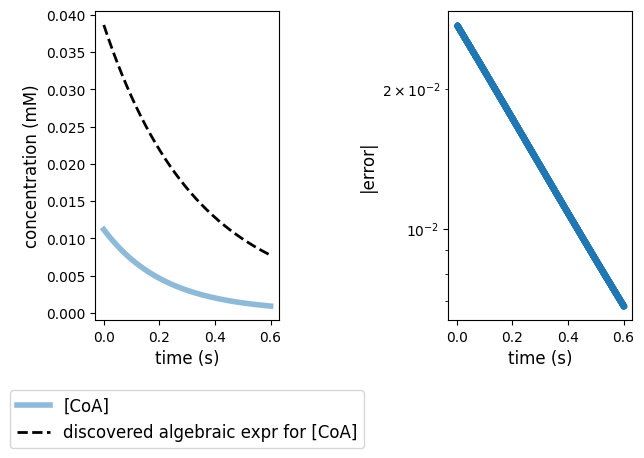

In [71]:
testAld = outs[0][:, 0]
testPc = outs[0][:, 2]

testLHS = np.multiply(testAld, testPc)
testRel = .054198*testAld + 23.02722*np.square(testPc)


plt.subplot(1, 2, 1)
plt.plot(tSolve, testLHS, lw=4, label='[CoA]', alpha=.5)
plt.plot(tSolve, testRel, '--k', lw=2, label='discovered algebraic expr for [CoA]')
plt.xlabel('time (s)', fontsize=12)
plt.ylabel('concentration (mM)', fontsize=12)
plt.legend(fontsize=12, loc=9, bbox_to_anchor=(0.5, -0.2))

plt.subplot(1, 2, 2)
plt.semilogy(tSolve, np.abs(np.subtract(testLHS, testRel)), '.')
plt.xlabel('time (s)', fontsize=12)
plt.ylabel('|error|', fontsize=12)

plt.tight_layout()
plt.show()